In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset 
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader

import matplotlib.pylab as plt
import numpy as np
import os
from tqdm import tqdm

from torchsummary import summary

/home/uichan/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#download mnist
mnist_train = dset.MNIST(root='./data/mnist', train=True, transform=transforms.ToTensor(),target_transform=None ,download=True)
mnist_test  = dset.MNIST(root='./data/mnist', train=False, transform=transforms.ToTensor(),target_transform=None ,download=True)

train_loadaer = DataLoader(mnist_train, batch_size=256, shuffle=True, num_workers=2, drop_last = True)
test_loader   = DataLoader(mnist_test, batch_size=256, shuffle=False, num_workers=2, drop_last = True)
print("download 완료!")

#param
lr = 0.00002
num_epoch = 1000

#model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            #conv
            nn.Conv2d(1,16,5), # 28 -> 24
            nn.ReLU(),
            nn.Conv2d(16,32,5), # 24 -> 20
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 20 -> 10
            nn.Conv2d(32,64,5), # 10 -> 6
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 6 -> 3
        )

        self.fc = nn.Sequential(
            nn.Linear(64*3*3, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

#optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

download 완료!
device : cuda:0


In [6]:
#train
loss_arr = []
for i in tqdm(range(num_epoch)):
    loss_sum = 0

    for [image,label] in test_loader:  #enumerate 사용시 인덱스와 튜플을 같이 넘겨줌
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x)
        _,output_max = torch.max(output,1)

        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.cpu().detach().numpy()

    loss_arr.append(loss_sum)

    torch.save({
        'epoch': i,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : loss.cpu().detach().numpy()
    },
    f"saved/checkpoint_{i}")


print("train 완료!\n")

 63%|██████▎   | 634/1000 [04:44<02:44,  2.23it/s]


KeyboardInterrupt: 

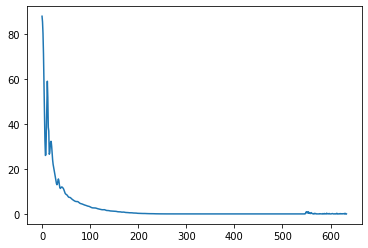

0.0001516568147295061


In [7]:
#print loss
plt.plot(loss_arr)
plt.show()
print(loss_arr[-1])

In [8]:
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 24, 24]             416
              ReLU-2           [-1, 16, 24, 24]               0
            Conv2d-3           [-1, 32, 20, 20]          12,832
              ReLU-4           [-1, 32, 20, 20]               0
         MaxPool2d-5           [-1, 32, 10, 10]               0
            Conv2d-6             [-1, 64, 6, 6]          51,264
              ReLU-7             [-1, 64, 6, 6]               0
         MaxPool2d-8             [-1, 64, 3, 3]               0
            Linear-9                  [-1, 100]          57,700
             ReLU-10                  [-1, 100]               0
           Linear-11                   [-1, 10]           1,010
Total params: 123,222
Trainable params: 123,222
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [9]:
model.state_dict()

OrderedDict([('layer.0.weight',
              tensor([[[[ 0.4145,  0.4785, -0.2280, -0.3842, -0.1721],
                        [ 0.5613,  0.3190, -0.3653, -0.4176,  0.1287],
                        [ 0.5949,  0.1633, -0.5386, -0.4016,  0.2821],
                        [ 0.5762,  0.2496, -0.3810, -0.2380,  0.3079],
                        [ 0.3090, -0.3509, -0.4687, -0.3757,  0.4265]]],
              
              
                      [[[-0.4231, -0.5373, -0.4019, -0.5907, -0.4584],
                        [-0.5134, -0.5728, -0.6630, -0.5651, -0.5608],
                        [-0.5352, -0.4456, -0.3263, -0.3505, -0.4234],
                        [-0.2955, -0.6509, -0.4400, -0.5952, -0.5201],
                        [-0.3653, -0.4649, -0.3640, -0.2963,  0.4070]]],
              
              
                      [[[-0.6425, -0.3409, -0.5871, -0.3849, -0.4535],
                        [-0.6274, -0.3047, -0.4316, -0.6272, -0.6392],
                        [-0.5546, -0.4110, -0.6157, 

In [10]:
#모델의 파라미터만 저장
torch.save(model.state_dict(), os.path.join("model/","only_param.pt"))

#아키텍쳐도 저장
torch.save(model, os.path.join("model/","with_architecture.pt"))

In [11]:
#파라미터만 저장했을때 의 블러오기
new_model_1 = CNN().to(device)
new_model_1.load_state_dict(torch.load(os.path.join("model/","only_param.pt")))


<All keys matched successfully>

In [12]:
#모델 자체를 불러오기
new_model_2 = torch.load(os.path.join("model/","with_architecture.pt"))

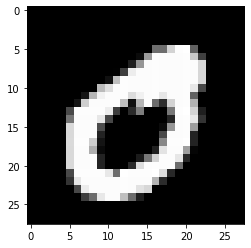

label : 0
infer : 0
True


In [13]:
#이미지 확인
random_num = np.random.randint(0, 10000)
image = mnist_test[random_num][0]

plt.imshow(image.reshape(-1,28),cmap="gray")
plt.show()
print(f"label : {mnist_test[random_num][1]}")
#infer
with torch.no_grad():
    #output = model.forward(image.reshape([1,1,28,28]).to(device))
    output = new_model_1.forward(image.reshape([1,1,28,28]).to(device))
    #output = new_model_2.forward(image.reshape([1,1,28,28]).to(device))
    _,output_max = torch.max(output,1)

print(f"infer : {int(output_max)}")
print(int(output_max)==mnist_test[random_num][1])